# Imports

In [1]:
# Clone a repository where all verbatlas frames have been saved.
!git clone "https://github.com/Omar659/verbatlas.git"

Cloning into 'verbatlas'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 27 (delta 1), reused 17 (delta 0), pack-reused 0
Unpacking objects: 100% (27/27), done.


In [2]:
from nltk.corpus import wordnet as wn
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

import csv
import json

from collections import defaultdict
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# VerbAtlas
Contains saved in dictionaries the various VerbAtlas files needed.


In [3]:
class VerbAtlas():
    def __init__(self, folder_path):
        # VA_bn2va.tsv: lists the BabelNet synsets in each VerbAtlas frame
        self.bn2va = self.__read_tsv(folder_path + "/VerbAtlas-1.1.0/VA_bn2va.tsv")
        self.bn_va_dict = [{}, defaultdict(lambda : [])]
        for bn2va_i in self.bn2va:
            self.bn_va_dict[0][bn2va_i[0]] = bn2va_i[1]
            self.bn_va_dict[1][bn2va_i[1]].append(bn2va_i[0])
            
        # bn2wn.tsv: mapping from BabelNet to WordNet
        self.bn2wn = self.__read_tsv(folder_path + "/VerbAtlas-1.1.0/bn2wn.tsv")
        self.bn_wn_dict = {}
        for bn2wn_i in self.bn2wn:
            self.bn_wn_dict[bn2wn_i[0]] = [bn2wn_i[1][3:-1], bn2wn_i[1][-1]]

        # VA_frame_info.tsv: mapping from VerbAtlas ID to all the frame information, 
        # including the frame name (second field)
        self.frame_info = self.__read_tsv(folder_path + "/VerbAtlas-1.1.0/VA_frame_info.tsv")
        self.frame_info_dict = {}
        for frame_info_i in self.frame_info:
            self.frame_info_dict[frame_info_i[0]] = frame_info_i[1:]

        # README of VerbAtlas
        with open(folder_path + "README.md") as file:
            my_file = csv.reader(file, delimiter="\t")
            readme = "\n".join([line[0] for line in my_file if line != []])
            print(readme)

    def __read_tsv(self, path):
        # Read a file from VerbAtlas
        tsv_file = []
        with open(path) as file:
            my_file = csv.reader(file, delimiter="\t")
            for line in list(my_file)[1:]:
                tsv_file.append(line)
        return tsv_file

# Verbatlas frames
vf = VerbAtlas("./verbatlas/")

                                VerbAtlas 1.1.0
                             http://verbatlas.org
               Andrea Di Fabio, Simone Conia and Roberto Navigli
               Sapienza NLP Group, Sapienza University of Rome
                             http://nlp.uniroma1.it
               Web site and resource maintenance by Babelscape
                             http://babelscape.com
VerbAtlas is a novel large-scale manually-crafted semantic resource for
wide-coverage, intelligible and scalable Semantic Role Labeling.
The goal of VerbAtlas is to manually cluster WordNet synsets that share similar
semantics into a set of semantically-coherent frames.
VerbAtlas is licensed under the CC BY-NC-SA 4.0 License.
PACKAGE CONTENTS
* README.txt (this file);
* LICENSES.txt (terms and conditions for the files provided in this package)
* VERBATLAS_LICENSE.txt (terms and conditions of the CC BY-NC-SA 4.0 License);
* WORDNET_LICENSE.txt (original license from WordNet 3.0);
* BABELNET_LICENSE.txt

# Functions


In [4]:
def pprint(obj):
    '''
        Indented print of an object
    '''
    print(json.dumps(obj, indent=3))

def ambiguities(synset2frames):
    '''
        Separates ambiguous nominal synsets from unambiguous ones. 
        Ambiguous means those nominal synsets derived from two different verbs 
        associated with two different VerbAtlas frames.
        Input:
            synset2frames: 
                dictionary with: {nominal_synset: VerbAtlas_frames_set}
        Output:
            ambiguous: 
                Dictionary like input but containing only ambiguous synsets
            not_ambiguous: 
                Dictionary like input but containing only unambiguous synsets
    '''
    ambiguous = {}
    not_ambiguous = {}
    for nominal_synset, verbatlas_frames in synset2frames.items():
        if len(verbatlas_frames) > 1:
            # More than one frame associated with this nominal synset.
            ambiguous[nominal_synset] = verbatlas_frames
        else:
            # A set of only one value since is unambiguous
            not_ambiguous[nominal_synset] = list(verbatlas_frames)[0]
    return ambiguous, not_ambiguous

def nominal_synset_derivation(vf):
    '''
        For each verb contained in BableNet (associated with a VerbAtlas frame) 
        a 1-to-1 match is found in WordNet. From the verb in WordNet 
        the derivationally related forms are derived and for each of these 
        the derivation tree is traced back through the hypernyms to the "Entity" synset. 
        At this point several statistics are captured.
        Input: 
            vf: VerbAtlas object (all files that are needed in the form of dictionaries)
        Output:
            event_ambiguous_nominal_synset:
                {nominal_synset: VerbAtlas_frames_set} dictionary where nominal_synsets are: 
                    - Those that have reached the "Event" synset by going up the hypernym tree. 
                    - They are ambiguous.
            event_not_ambiguous_nominal_synset:
                {nominal_synset: VerbAtlas_frames_set} dictionary where nominal_synsets are: 
                    - Those that have reached the "Event" synset by going up the hypernym tree. 
                    - They are not ambiguous.
            not_event_ambiguous_nominal_synset:
                {nominal_synset: VerbAtlas_frames_set} dictionary where nominal_synsets are: 
                    - Those that didn't reached the "Event" synset by going up the hypernym tree. 
                    - They are not ambiguous.
            not_event_not_ambiguous_nominal_synset:
                {nominal_synset: VerbAtlas_frames_set} dictionary where nominal_synsets are: 
                    - Those that didn't reached the "Event" synset by going up the hypernym tree. 
                    - They are not ambiguous.
            nominal_synset2event_number:
                Number of nominal_synsets that reached event.            
            nominal_synset2not_event_number:
                Number of nominal_synsets that didn't reach event.
            no_derivationally_related_forms_count:
                Number of verb_synsets without a derivationally related form.
            va_frame_frequencies_if_event:
                {VerbAtlas_frame: {synset: frequency}} dictionary where each VerbAtlas frame 
                is associated with a dictionary. In this dictionary each synset is associated with a frequency. 
                The synsets contained in this dictionary are the synsets visited within the derivation tree by hypernyms. 
                However, some synsets can be reached by starting from different nominal_synsets. 
                For this reason, a frequency is associated that says: 
                    "how many times a given synset was reached via hypernyms 
                     starting from verbs belonging to the same VerbAtlas frame".
    '''
    # event_nominal_synset -> frame
    event_nom_syn2va_frames = defaultdict(lambda : set())
    # not_event_nominal_synset -> frame
    not_event_nom_syn2va_frames = defaultdict(lambda : set())
    # VerbAtlas_frame -> (synset -> frequency)
    va_frame_frequencies_if_event = defaultdict(lambda : defaultdict(lambda : 0))
    # Number of verb_synsets without a derivationally related form
    no_derivationally_related_forms_count = 0
    # For each "bablnet to wordnet" verb.
    for bablenet_id, [wn_offset, wn_pos] in vf.bn_wn_dict.items():
        synset = wn.synset_from_pos_and_offset(wn_pos, int(wn_offset))
        # Lemmas from the verb synsets
        synset_lemmas = synset.lemmas()
        nominal_synsets = set()
        # Find nominal_synsets
        for synset_lemma in synset_lemmas:
            drfs = synset_lemma.derivationally_related_forms()
            for drf in drfs:
                pos = drf.synset().pos()
                if pos == "n":
                    nominal_synsets.add(drf.synset())
        # No nominal_synsets found
        if nominal_synsets == set():
            no_derivationally_related_forms_count += 1
        # Derive the hypernym tree and save the path, for each nominal_synset
        for nominal_synset in nominal_synsets:
            synsets_to_hypernym = set([nominal_synset])
            visited = set()
            while synsets_to_hypernym != set():
                synset_to_hypernym = synsets_to_hypernym.pop()
                visited.add(synset_to_hypernym)
                hypernyms = synset_to_hypernym.hypernyms()
                for hypernym in hypernyms:
                    lemmas = hypernym.lemmas()
                    for lemma in lemmas:
                        pos = lemma.synset().pos()
                        if pos == "n":
                            synsets_to_hypernym.add(lemma.synset())
            va_frame = vf.frame_info_dict[vf.bn_va_dict[0][bablenet_id]][0]
            # If a nomina_synset reach "event"
            if set(wn.synsets("event")).intersection(visited) != set():
                event_nom_syn2va_frames[nominal_synset].add(va_frame)
                # Save path and frequencies
                for hypernym in visited:
                    va_frame_frequencies_if_event[va_frame][hypernym] += 1
            else:
                not_event_nom_syn2va_frames[nominal_synset].add(va_frame)
    # Divide the ambiguous from the unambiguous
    event_ambiguous_nominal_synset, event_not_ambiguous_nominal_synset = ambiguities(event_nom_syn2va_frames)
    not_event_ambiguous_nominal_synset, not_event_not_ambiguous_nominal_synset = ambiguities(not_event_nom_syn2va_frames)
    nominal_synset2event_number = len(event_nom_syn2va_frames)
    nominal_synset2not_event_number = len(not_event_nom_syn2va_frames)
    return (event_ambiguous_nominal_synset, 
            event_not_ambiguous_nominal_synset, 
            not_event_ambiguous_nominal_synset,
            not_event_not_ambiguous_nominal_synset,
            nominal_synset2event_number, 
            nominal_synset2not_event_number, 
            no_derivationally_related_forms_count,
            va_frame_frequencies_if_event)

def manipulate_statistics(va_frame_frequencies_if_event):
    '''
        In order to resolve ambiguous cases, it was necessary to manipulate the collected statistics.
        Input:
            va_frame_frequencies_if_event:
                {VerbAtlas_frame: {synset: frequency}} dictionary where each VerbAtlas frame 
                is associated with a dictionary. In this dictionary each synset is associated with a frequency. 
                The synsets contained in this dictionary are the synsets visited within the derivation tree by hypernyms. 
                However, some synsets can be reached by starting from different nominal_synsets. 
                For this reason, a frequency is associated that says: 
                    "how many times a given synset was reached via hypernyms 
                     starting from verbs belonging to the same VerbAtlas frame".
        Output:
            out: 
                Same as input but with a skim:
                    - Synsets that appeared in at least one-third of the frames were removed.
                    - For each remaining synset, only the copy with maximum frequency was retained. 
                      Copies are generated because same synsets are reachable from verbs associated 
                      with different frames. Briefly, for each frame, if the synset 
                      has maximum frequency relative to the other frames, then it is kept otherwise it is removed.
    '''
    print("MANIPULATE STATISTICS")
    # Number of frames
    n_frame = len(va_frame_frequencies_if_event.items())
    
    # Step 1: Create a set with all synsets found in the various paths from the unambiguous nominal synsets
    all_non_ambiguous_syns = set()
    for i, (frame, syns2freq) in enumerate(va_frame_frequencies_if_event.items()):
        print("\r\tSTEP 1 - Set of synsets found from non ambiguous nominal synset for each frame:\t" + str(i+1) + "/" + str(n_frame) + " frames.", end = "")
        all_non_ambiguous_syns.update(list(syns2freq.keys()))
    print("\r\tSTEP 1 - Set of synsets found from non ambiguous nominal synset for each frame:\t" + str(i+1) + "/" + str(n_frame) + " frames.\t\tDONE", end = "")
    print()

    # Phase 2: Make a dictionary that with each synset associates how many times it appears
    non_ambiguous_syns_len = len(all_non_ambiguous_syns)
    non_ambiguous_syns_in_frame = defaultdict(lambda : 0)
    for i, non_ambiguous_syn in enumerate(all_non_ambiguous_syns):
        print("\r\tSTEP 2 - Synsets frequencies in general:\t\t\t\t\t" + str(i+1) + "/" + str(non_ambiguous_syns_len) + " synsets.", end = "")
        for syns2freq in va_frame_frequencies_if_event.values():
            if non_ambiguous_syn in list(syns2freq.keys()):
                non_ambiguous_syns_in_frame[non_ambiguous_syn] += 1
                continue
    print("\r\tSTEP 2 - Synsets frequencies in general:\t\t\t\t\t" + str(i+1) + "/" + str(non_ambiguous_syns_len) + " synsets.\tDONE", end = "")
    print()

    # Phase 3: Remove synsets that appear in at least one-third of the frames
    ok_synsets = set()
    for i, (synset, frequency) in enumerate(non_ambiguous_syns_in_frame.items()):
        print("\r\tSTEP 3 - Remove synsets that appear in at least one-third of the frames:\t" + str(i+1) + "/" + str(non_ambiguous_syns_len) + " synsets.", end = "")
        if frequency < round(n_frame/3):
            ok_synsets.add(synset)
    print("\r\tSTEP 3 - Remove synsets that appear in at least one-third of the frames:\t" + str(i+1) + "/" + str(non_ambiguous_syns_len) + " synsets.\tDONE", end = "")
    print()

    # Phase 4: For each remaining synset keep, for each frame, only the synsets that have maximum frequency relative to the other frames
    out = defaultdict(lambda : {})
    ok_synsets_len = len(ok_synsets)
    for i, ok_synset in enumerate(ok_synsets):
        print("\r\tSTEP 4 - Keep, for each frame, only the synsets with max frequency:\t\t" + str(i+1) + "/" + str(ok_synsets_len) + " ok synsets.", end = "")
        max_value = 0
        max_key = ""
        for frame, syns2freq in va_frame_frequencies_if_event.items():
            for synset, frequency in syns2freq.items():
                if synset == ok_synset and frequency > max_value:
                    max_value = frequency
                    max_key = frame
        out[max_key][ok_synset] = max_value
    print("\r\tSTEP 4 - Keep, for each frame, only the synsets with max frequency:\t\t" + str(i+1) + "/" + str(ok_synsets_len) + " ok synsets.\tDONE", end = "")
    return out

def disambiguate(va_frame2syns2freq, event_ambiguous_nominal_synset, threshold = -1):
    '''
        Try disambiguating those nominal synsets that are derived from different frame verbs. 
        To do this, use the frequencies in which certain synsets appear along the hypernym path to "event".
        If in the path of hypernyms up to "event" there exists a synset seen in a path obtained from an unambiguous nominal synset:
            if that nominal synset was derived from one of the ambiguity frames of the ambiguous nominal synset:
                then most likely the ambiguous nominal synset belongs to this frame.
        Not only that, the synsets within the path of the nominal synset, used for comparison, 
        are only those that are then associated with the nominal synset derived 
        from the frame that has obtained a maximum visit frequency to those synsets.
        Input:
            va_frame2syns2freq:
                {VerbAtlas_frame: {synset: frequency}} dictionary where each VerbAtlas frame 
                is associated with a dictionary. In this dictionary each synset is associated with a frequency. 
                The synsets contained in this dictionary are the synsets visited within the derivation tree by hypernyms. 
                However, some synsets can be reached by starting from different nominal_synsets. 
                For this reason, a frequency is associated that says: 
                    "how many times a given synset was reached via hypernyms 
                     starting from verbs belonging to the same VerbAtlas frame".
                This dictionary was skimmed following these guides:
                    - Synsets that appeared in at least one-third of the frames were removed.
                    - For each remaining synset, only the copy with maximum frequency was retained. 
                      Copies are generated because same synsets are reachable from verbs associated 
                      with different frames. Briefly, for each frame, if the synset 
                      has maximum frequency relative to the other frames, then it is kept otherwise it is removed.
            event_ambiguous_nominal_synset:
                {nominal_synset: VerbAtlas_frames_set} dictionary where nominal_synsets are: 
                    - Those that have reached the "Event" synset by going up the hypernym tree. 
                    - They are ambiguous.
            threshold: (defualt = -1)
                For each frame, only synsets that have frequency greater than the threshold are considered
                If less than 0 then it prints how many nominal synsets were disambiguated using all possible thresholds.
                If greater than or equal to 0 then it disambiguates the nominal synsets using this threshold
        Output:
            nominal_synset_disambiguate: (if threshold >= 0)
                {
                    nominal_synset: 
                        {
                                "Definition": synset.definition(), 
                                "Ambiguous_value_chosen": frame,
                                "List_from_which_ambiguous_value_is_chosen": list_of_frames)
                        }
                }
    '''
    threshold_j = 0 if threshold == -1 else threshold
    threshold2disambiguates = {}
    while True:
        # VerbAtlas frame -> (synset -> frequency)
        statistics = {}
        # Apply threshold
        for frame, syns2freq in va_frame2syns2freq.items():
            ordered_value = list(syns2freq.items())
            ordered_value.sort(key = lambda x: x[1], reverse = True)
            new_value = [i for i in ordered_value if i[1] > threshold_j]
            if new_value != []:
                statistics[frame] = new_value
        nominal_synset_disambiguate = defaultdict(lambda : {"Definition": "",
                                                            "Ambiguous_value_chosen": "", 
                                                            "List_from_which_ambiguous_value_is_chosen": []})
        for ambiguous_nominal_syns, frames in event_ambiguous_nominal_synset.items():
            if frames.intersection(set(list(statistics.keys()))) != set():
                # Hypernyms paths
                synsets_to_hypernym = set([ambiguous_nominal_syns])
                visited = set()
                while synsets_to_hypernym != set():
                    synset_to_hypernym = synsets_to_hypernym.pop()
                    visited.add(synset_to_hypernym)
                    hypernyms = synset_to_hypernym.hypernyms()
                    for hypernym in hypernyms:
                        lemmas = hypernym.lemmas()
                        for lemma in lemmas:
                            pos = lemma.synset().pos()
                            if pos == "n":
                                synsets_to_hypernym.add(lemma.synset())
                # For each frame, search if there is a synset in the path that is contained in the list of synsets for that frame
                for frame in frames:
                    frequent_synset = statistics.get(frame)
                    if frequent_synset is not None:
                        frequent_synset_set = set([syns2freq[0] for syns2freq in frequent_synset])
                        if frequent_synset_set.intersection(visited) != set():
                            nominal_synset_disambiguate[ambiguous_nominal_syns]["Ambiguous_value_chosen"] = frame
                            nominal_synset_disambiguate[ambiguous_nominal_syns]["List_from_which_ambiguous_value_is_chosen"] = list(frames)
                            nominal_synset_disambiguate[ambiguous_nominal_syns]["Definition"] = ambiguous_nominal_syns.definition()
        # If the threshold is to much high or we want loop over threshold_j, break
        if len(nominal_synset_disambiguate) == 0 or threshold >= 0:
            break
        threshold2disambiguates[threshold_j] = len(nominal_synset_disambiguate)
        print("With min frquencey", threshold_j, "\nI disambiguate", len(nominal_synset_disambiguate), "nominal synset\n")
        threshold_j += 1
    if threshold >= 0:
        return nominal_synset_disambiguate
    else:
        return threshold2disambiguates

#Statistics

##Collect statistics and data
All the necessary dictionaries are saved and also shown how the synsets are divided.

In [5]:
event_ambiguous_nominal_synset,         \
event_not_ambiguous_nominal_synset,     \
not_event_ambiguous_nominal_synset,     \
not_event_not_ambiguous_nominal_synset, \
nominal_synset2event_number,            \
nominal_synset2not_event_number,        \
no_derivationally_related_forms_count,  \
va_frame_frequencies_if_event           = nominal_synset_derivation(vf)

In [6]:
print("VERBAL SYNSETS\t\t\t", len(vf.bn2wn))

print("\tWithout related forms:\t", no_derivationally_related_forms_count)
print("\tWith related forms:\t", len(vf.bn2wn) - no_derivationally_related_forms_count)


print("\nNOMINAL SYNSETS\t\t\t", nominal_synset2event_number + nominal_synset2not_event_number)

print("\tEvent synsets:\t\t", nominal_synset2event_number)
print("\t\tAmbiguous:\t", len(event_ambiguous_nominal_synset))
print("\t\tNon ambiguous:\t", len(event_not_ambiguous_nominal_synset))

print("\n\tNot event synsets:\t", nominal_synset2not_event_number)
print("\t\tAmbiguous:\t", len(not_event_ambiguous_nominal_synset))
print("\t\tNon ambiguous:\t", len(not_event_not_ambiguous_nominal_synset))

VERBAL SYNSETS			 13767
	Without related forms:	 4833
	With related forms:	 8934

NOMINAL SYNSETS			 11751
	Event synsets:		 3480
		Ambiguous:	 965
		Non ambiguous:	 2515

	Not event synsets:	 8271
		Ambiguous:	 1860
		Non ambiguous:	 6411


##Use of frequencies

Manipulate the frequencies

In [7]:
frequencies = manipulate_statistics(va_frame_frequencies_if_event)

MANIPULATE STATISTICS
	STEP 1 - Set of synsets found from non ambiguous nominal synset for each frame:	407/407 frames.		DONE
	STEP 2 - Synsets frequencies in general:					3818/3818 synsets.	DONE
	STEP 3 - Remove synsets that appear in at least one-third of the frames:	3818/3818 synsets.	DONE
	STEP 4 - Keep, for each frame, only the synsets with max frequency:		3808/3808 ok synsets.	DONE

Shows how many ambiguous nominal synsets are disambiguated using all possible threshold values for the minimum frequency

In [8]:
threshold2disambiguates = disambiguate(frequencies, event_ambiguous_nominal_synset)

With min frquencey 0 
I disambiguate 907 nominal synset

With min frquencey 1 
I disambiguate 691 nominal synset

With min frquencey 2 
I disambiguate 573 nominal synset

With min frquencey 3 
I disambiguate 510 nominal synset

With min frquencey 4 
I disambiguate 445 nominal synset

With min frquencey 5 
I disambiguate 405 nominal synset

With min frquencey 6 
I disambiguate 359 nominal synset

With min frquencey 7 
I disambiguate 324 nominal synset

With min frquencey 8 
I disambiguate 297 nominal synset

With min frquencey 9 
I disambiguate 277 nominal synset

With min frquencey 10 
I disambiguate 253 nominal synset

With min frquencey 11 
I disambiguate 221 nominal synset

With min frquencey 12 
I disambiguate 212 nominal synset

With min frquencey 13 
I disambiguate 192 nominal synset

With min frquencey 14 
I disambiguate 183 nominal synset

With min frquencey 15 
I disambiguate 183 nominal synset

With min frquencey 16 
I disambiguate 176 nominal synset

With min frquencey 17 
I

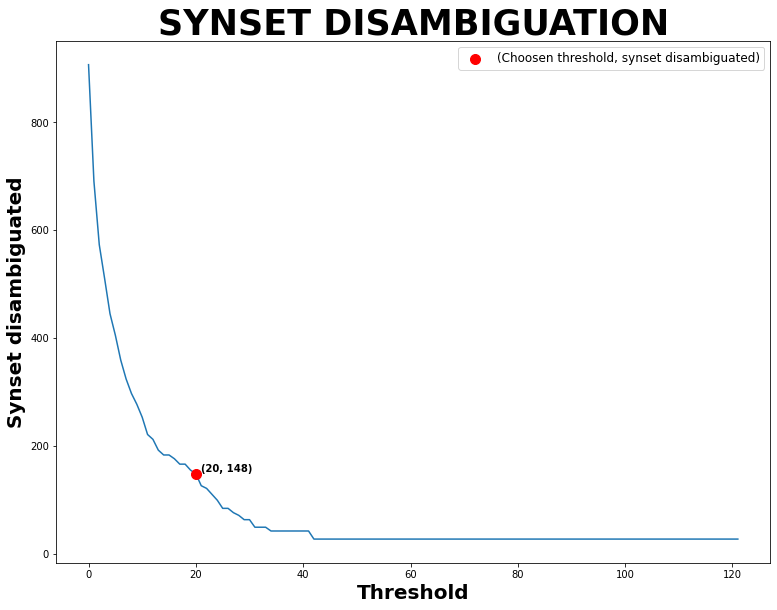

In [9]:
choosen_threshold = 20
threshold = list(threshold2disambiguates.keys())
n_disambigued = list(threshold2disambiguates.values())

plt.figure(figsize=(6.4*2, 4.8*2), constrained_layout=False)
plt.plot(threshold, n_disambigued)
plt.scatter(threshold[choosen_threshold], 
            n_disambigued[choosen_threshold], 
            color = "red", 
            zorder = 5, 
            s = 100,
            label = "(Choosen threshold, synset disambiguated)")
plt.text(threshold[choosen_threshold] + 1, 
         n_disambigued[choosen_threshold] + 1, 
         "(" + str(threshold[choosen_threshold]) + ", " + str(n_disambigued[choosen_threshold]) + ")", 
         ha = "left", va = "bottom",
         fontweight='bold', 
        #  size = SCALE_TEXT*scale_plot, 
         zorder = 4)

plt.xlabel("Threshold", fontweight='bold', size = 20)
plt.ylabel("Synset disambiguated", fontweight='bold', size = 20)
plt.title("SYNSET DISAMBIGUATION", fontweight='bold', size = 35)
plt.legend(loc=0, prop={'size': 12})

Data frame showing the results obtained with a specific hand-picked threshold.

In [10]:
synset_disambiguated = disambiguate(frequencies, event_ambiguous_nominal_synset, threshold = choosen_threshold)
df = pd.DataFrame(synset_disambiguated)
df = df.T
df['Synset_counter'] = np.arange(len(df))
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df

,Synset_counter,Definition,Ambiguous_value_chosen,List_from_which_ambiguous_value_is_chosen
Synset('contraction.n.04'),0,the act of decreasing (something) in size or v...,REDUCE_DIMINISH,"[REDUCE_DIMINISH, SUMMARIZE]"
Synset('accumulation.n.03'),1,the act of accumulating,INCREASE_ENLARGE_MULTIPLY,"[AMASS, POSSESS, INCREASE_ENLARGE_MULTIPLY]"
Synset('adjuration.n.01'),2,a solemn and earnest appeal to someone to do s...,ASK_REQUEST,"[ASK_REQUEST, ORDER]"
Synset('telling.n.02'),3,informing by words,SPEAK,"[SPEAK, INFORM]"
Synset('pretense.n.01'),4,the act of giving a false appearance,DECEIVE,"[SIMULATE, DECEIVE]"
...,...,...,...,...
Synset('walk.n.01'),143,the act of traveling by foot,TRAVEL,"[MOVE-SOMETHING, TRAVEL, GO-FORWARD, OVERCOME_..."
Synset('walk.n.04'),144,the act of walking somewhere,TRAVEL,"[TRAVEL, GO-FORWARD, OVERCOME_SURPASS]"
Synset('tickle.n.02'),145,the act of tickling,TOUCH,"[AROUSE_WAKE_ENLIVEN, TOUCH]"
Synset('twang.n.01'),146,a sharp vibrating sound (as of a plucked string),MAKE-A-SOUND,"[PERFORM, MAKE-A-SOUND]"


#Save

In [11]:
# e.g. wn:00001740n -> FOLLOW_SUPPORT_SPONSOR_FUND
to_save = []
# The first elements are the unambiguous ones
for nominal_synset, frame in event_not_ambiguous_nominal_synset.items():
    zero_numbers = 8-len(str(nominal_synset.offset()))
    nominal_synset_encoded = "wn:" + "0"*zero_numbers + str(nominal_synset.offset()) + nominal_synset.pos()
    to_save.append([nominal_synset_encoded, frame])
# The second elements are the ambiguous ones
for nominal_synset, frame_info in synset_disambiguated.items():
    zero_numbers = 8-len(str(nominal_synset.offset()))
    nominal_synset_encoded = "wn:" + "0"*zero_numbers + str(nominal_synset.offset()) + nominal_synset.pos()
    to_save.append((nominal_synset_encoded, frame_info["Ambiguous_value_chosen"]))
# Save
with open('results.tsv', 'w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t', lineterminator='\n')
    for row in to_save:
        writer.writerow(row)